**README**: Before you run the notebook, ensure you have the following files in the Current Working Directory

- proof_outcomes_by_problem.json

# Initialization

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import json

## Process Proofs

In [2]:
import json

with open('proof_outcomes_by_problem.json') as json_file:
    proof_outcomes_by_problem = json.load(json_file)

In [3]:
proof_outcomes_by_problem['0']['AI-MO_Kimina-Prover-Preview-Distill-7B']

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]

Using ensemble: ['AI-MO_Kimina-Prover-Preview-Distill-7B', 'Goedel-LM_Goedel-Prover-SFT', 'deepseek-ai_DeepSeek-Prover-V2-7B']
Individual model coverages: {'AI-MO_Kimina-Prover-Preview-Distill-7B': 72, 'Goedel-LM_Goedel-Prover-SFT': 87, 'deepseek-ai_DeepSeek-Prover-V2-7B': 83}

Ensemble vs Best Individual Results (10000 trials):
Wins: 10000 (100.0%)
Ties: 0 (0.0%)
Losses: 0 (0.0%)
Ensemble no worse than best single model: 10000 (100.0%)

--------------------------------------------------------
1. Best individual performance : 87 problems
2. Average ensemble performance: 94.6 problems
3. Avg abs diff (|ensemble - best individual|): 7.6 problems
4. Avg pct diff ((ensemble - best)/best*100)  : +8.7 %
--------------------------------------------------------

Trial results summary:
result
win    10000
Name: count, dtype: int64


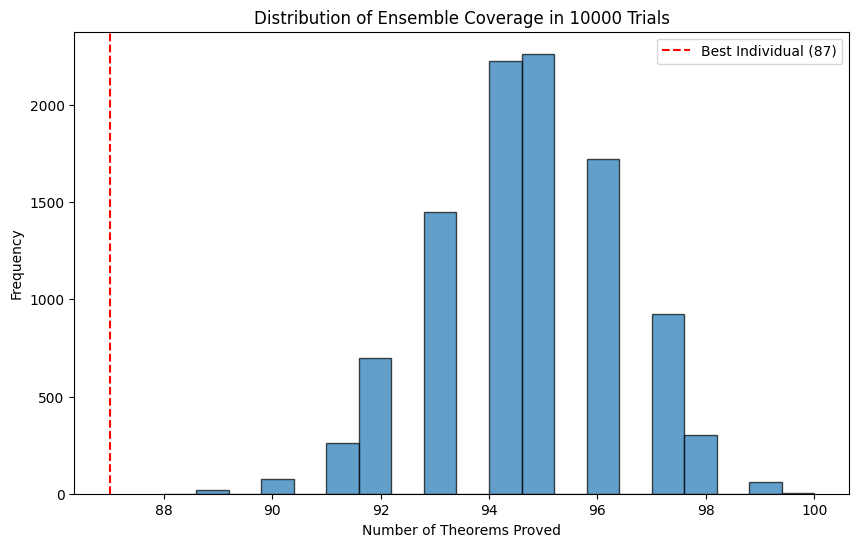

In [ ]:
from typing import List, Dict, Tuple
import random

random.seed(42)

def compare_ensemble_vs_individuals(proof_outcomes_by_problem: dict,
                                   ensemble_models: List[str],
                                   n_trials: int = 100,
                                   attempts_per_model: int = 2) -> Dict:
    """
    Compare ensemble performance against individual models by randomly sampling attempts.

    Args:
        proof_outcomes_by_problem: Dictionary with proof outcomes
        ensemble_models: List of model names in the ensemble
        n_trials: Number of random sampling trials
        attempts_per_model: Number of attempts to sample per model in ensemble

    Returns:
        Dictionary with comparison results
    """
    problem_indices = sorted(proof_outcomes_by_problem.keys(), key=int)

    # Calculate individual model performances
    individual_performances = {}
    for model in ensemble_models:
        successes = 0
        for problem_idx in problem_indices:
            if model in proof_outcomes_by_problem[problem_idx]:
                # OR-aggregate attempts for individual model
                attempts = proof_outcomes_by_problem[problem_idx][model]
                if any(attempts):  # If any attempt succeeds
                    successes += 1
        individual_performances[model] = successes

    best_individual_coverage = max(individual_performances.values())
    best_individual_model = [m for m, cov in individual_performances.items()
                           if cov == best_individual_coverage][0]

    print(f"Individual model coverages: {individual_performances}")
    
    # Run ensemble trials
    ensemble_wins = 0
    ensemble_ties = 0
    ensemble_losses = 0
    trial_results = []

    for trial in range(n_trials):
        ensemble_successes = 0

        for problem_idx in problem_indices:
            problem_solved = False

            for model in ensemble_models:
                if model in proof_outcomes_by_problem[problem_idx]:
                    attempts = proof_outcomes_by_problem[problem_idx][model]

                    # Randomly sample attempts_per_model attempts
                    if len(attempts) >= attempts_per_model:
                        sampled_attempts = random.sample(attempts, attempts_per_model)
                    else:
                        sampled_attempts = attempts

                    # Check if any sampled attempt succeeds for this model
                    if any(sampled_attempts):
                        problem_solved = True
                        break

            if problem_solved:
                ensemble_successes += 1

        # Compare with best individual
        if ensemble_successes > best_individual_coverage:
            ensemble_wins += 1
            result = "win"
        elif ensemble_successes == best_individual_coverage:
            ensemble_ties += 1
            result = "tie"
        else:
            ensemble_losses += 1
            result = "loss"

        trial_results.append({
            'trial': trial,
            'ensemble_coverage': ensemble_successes,
            'result': result
        })

    # Calculate statistics
    win_rate = ensemble_wins / n_trials
    tie_rate = ensemble_ties / n_trials
    loss_rate = ensemble_losses / n_trials

    print(f"\nEnsemble vs Best Individual Results ({n_trials} trials):")
    print(f"Wins: {ensemble_wins} ({win_rate:.1%})")
    print(f"Ties: {ensemble_ties} ({tie_rate:.1%})")
    print(f"Losses: {ensemble_losses} ({loss_rate:.1%})")
    print(f"Ensemble no worse than best single model: {ensemble_wins + ensemble_ties} ({(win_rate + tie_rate):.1%})")

    avg_ensemble_cov   = sum(t['ensemble_coverage'] for t in trial_results) / n_trials

    abs_diffs  = [abs(t['ensemble_coverage'] - best_individual_coverage) for t in trial_results]
    pct_diffs  = [(t['ensemble_coverage'] - best_individual_coverage) / best_individual_coverage * 100
                  for t in trial_results]

    print("\n--------------------------------------------------------")
    print(f"1. Best individual performance : {best_individual_coverage} problems")
    print(f"2. Average ensemble performance: {avg_ensemble_cov:.1f} problems")
    print(f"3. Avg abs diff (|ensemble - best individual|): {sum(abs_diffs)/n_trials:.1f} problems")
    print(f"4. Avg pct diff ((ensemble - best)/best*100)  : {sum(pct_diffs)/n_trials:+.1f} %")
    print("--------------------------------------------------------")


    return {
        'individual_performances': individual_performances,
        'best_individual_coverage': best_individual_coverage,
        'best_individual_model': best_individual_model,
        'trial_results': trial_results,
        'summary': {
            'n_trials': n_trials,
            'wins': ensemble_wins,
            'ties': ensemble_ties,
            'losses': ensemble_losses,
            'win_rate': win_rate,
            'tie_rate': tie_rate,
            'loss_rate': loss_rate
        }
    }

models = ['AI-MO_Kimina-Prover-Preview-Distill-7B', 'Goedel-LM_Goedel-Prover-SFT', 'deepseek-ai_DeepSeek-Prover-V2-7B']
print(f"Using ensemble: {models}")

# Run the comparison
results = compare_ensemble_vs_individuals(
    proof_outcomes_by_problem,
    models,
    n_trials=10000,
    attempts_per_model=8
)

results_df = pd.DataFrame(results['trial_results'])
print("\nTrial results summary:")
print(results_df['result'].value_counts())

# Plot the distribution of ensemble coverages
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(results_df['ensemble_coverage'], bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=results['best_individual_coverage'], color='red', linestyle='--',
            label=f'Best Individual ({results["best_individual_coverage"]})')
plt.xlabel('Number of Theorems Proved')
plt.ylabel('Frequency')
plt.title(f'Distribution of Ensemble Coverage in {results["summary"]["n_trials"]} Trials')
plt.legend()
plt.show()